# Answer Question 4 (Patrick)

What characteristics are predictors for changes in life expectancy in a country over time?


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for now we don't have preprocessed data, so we use the raw data 
data_raw = pd.read_csv('data/processed/merged_data.csv')
data_raw.set_index(['Country','Year'], inplace=True)

#this is the data processed from attila
df_data_preprocessed = pd.read_csv('data/processed/data_time_clean.csv')
df_data_preprocessed.set_index(['Country','Year'], inplace=True)

In [90]:

# do some quick processing so we can work with it and are consitant with the preprocessed data
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
df_data = data_raw.drop(columns=['Last Updated: 11/14/2018', 'Data from database: World Development Indicators', 'GNI, Atlas method (current US$)'] )
display(df_data.head(5))

# do some quick processing so we can work with it 
df_data_preprocessed.drop(df_data_preprocessed.columns[0], axis=1,inplace=True)
display(df_data_preprocessed.head(5))



LE_both  LE_male  LE_female Income Level  GDP per Capita  \
Country     Year                                                             
Afghanistan 2016     62.7     61.0       64.5            L      561.778746   
            2015     63.2     61.8       64.7            L      569.577923   
            2014     63.0     61.7       64.4            L      629.345250   
            2013     62.7     61.5       64.1            L      638.612543   
            2012     62.2     60.9       63.6            L      669.009051   

                  Surface area (sq. km)  Population, total  \
Country     Year                                             
Afghanistan 2016               652860.0         34656032.0   
            2015               652860.0         33736494.0   
            2014               652860.0         32758020.0   
            2013               652860.0         31731688.0   
            2012               652860.0         30696958.0   

                  Population density (people per sq. km of land area)  \
Country     Year                                                        
Afghanistan 2016                                          53.083405     
            2015                                          51.674929     
            2014                                          50.176179     
            2013                                          48.604123     
            2012                                          47.019205     

                  PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)  \
Country     Year                                                                           
Afghanistan 2016                                          62.854857                        
            2015                                          62.080234                        
            2014                                          49.036091                        
            2013                                          50.968831                        
            2012                                          50.653945                        

                  Mortality caused by road traffic injury (per 100,000 people)  \
Country     Year                                                                 
Afghanistan 2016                                                NaN              
            2015                                               15.2              
            2014                                                NaN              
            2013                                                NaN              
            2012                                                NaN              

                  Intentional homicides (per 100,000 people)  \
Country     Year                                               
Afghanistan 2016                                         NaN   
            2015                                         NaN   
            2014                                         NaN   
            2013                                         NaN   
            2012                                    6.345906   

                  Individuals using the Internet (% of population)  \
Country     Year                                                     
Afghanistan 2016                                         10.595726   
            2015                                          8.260000   
            2014                                          7.000000   
            2013                                          5.900000   
            2012                                          5.454545   

                  Incidence of tuberculosis (per 100,000 people)  \
Country     Year                                                   
Afghanistan 2016                                           189.0   
            2015                                           189.0   
            2014                                           189.0   
            2013        

LE_both  LE_male  LE_female Income Level  GDP per Capita  \
Country Year                                                             
Algeria 2016     76.4     75.4       77.4           UM     3916.881571   
        2015     76.2     75.3       77.2           UM     4160.220067   
        2014     76.1     75.1       77.1           UM     5466.425778   
        2013     75.9     75.0       76.9           UM     5471.123389   
        2012     75.8     74.8       76.8           UM     5565.134521   

              Surface area (sq. km)  Population, total  \
Country Year                                             
Algeria 2016              2381740.0         40606052.0   
        2015              2381740.0         39871528.0   
        2014              2381740.0         39113313.0   
        2013              2381740.0         38338562.0   
        2012              2381740.0         37565847.0   

              Population density (people per sq. km of land area)  \
Country Year                                                        
Algeria 2016                                          17.048895     
        2015                                          16.740504     
        2014                                          16.422159     
        2013                                          16.096871     
        2012                                          15.772438     

              PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)  \
Country Year                                                                           
Algeria 2016                                          37.230956                        
        2015                                          37.035728                        
        2014                                          33.080627                        
        2013                                          31.009854                        
        2012                                          28.209439                        

              Mortality caused by road traffic injury (per 100,000 people)  \
Country Year                                                                 
Algeria 2016                                              19.55              
        2015                                              23.70              
        2014                                              23.90              
        2013                                              24.10              
        2012                                              24.30              

              Intentional homicides (per 100,000 people)  \
Country Year                                               
Algeria 2016                                    2.777717   
        2015                                    1.359366   
        2014                                    1.475201   
        2013                                    1.252003   
        2012                                    1.392222   

              Individuals using the Internet (% of population)  \
Country Year                                                     
Algeria 2016                                         42.945527   
        2015                                         38.200000   
        2014                                         29.500000   
        2013                                         22.500000   
        2012                                         18.200000   

              Incidence of tuberculosis (per 100,000 people)  \
Country Year                                                   
Algeria 2016                                            70.0   
        2015                                            74.0   
        2014                                            72.0   
        2013                                            67.0   
        2012                                            73.0   

              GNI, Atlas method (current US$)  \
Country Year                                    
Algeria 2

In [91]:
#the preprocessed data 

# Correlations: 

We start by looking at cross-correlation of our time-series data per country. This should give us an first impression if some variables linearly correlate. 
We assume that all characteristics from a country at time t have some influence on the life expectancy at time t+x. Thus we try different shifted values to find the highest correlation by shifting the life expectancy up. (newer life exp. values with older values of country characteristic) 

In [92]:
# this helper creates a new dataframe with the shifted data
def create_lagged_df(df,lag=0,columns_to_shift = [] ):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x in columns_to_shift:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df


In [93]:

def calculate_cross_correlation( data ):

    data = data.copy()
    #print(data.columns[1:3].tolist())
    #for now we just use Both Sex
    #print(data.columns[:1].tolist())
    data.drop(data.columns[1:3].tolist(),axis=1,inplace=True)
    lag = 8
    df_lagged = create_lagged_df(data, lag, data.columns[:1].tolist() )
    #since the first lagged rows are useless because they are NaN we need to drop them 
    df_lagged = df_lagged.iloc[lag:]
    #display(df_lagged)

    ## now let calculate correlation 
    df_corr = df_lagged.corr('spearman')
    #df_corr = df_lagged.corr()
    #kendall corr  not rely on any assumptions on the distributions
    
    ## filter just the interesting correlations 
    #we are insterested in all row for life exp 
    df_corr = df_corr.filter(regex='LE_*',axis=0)
    # and all columns beside life exp. 
    df_corr = df_corr.filter(regex='^(?!LE).*$',axis=1)
    
    
    #display(df_corr)
    return df_corr

def display_cross_correlation( corr ):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(15,10))
    plt.title(u'Cross correlation', y=1.05, size=16)
    svm = sns.heatmap(corr,  linewidths=0.1,vmax=1.0, 
    square=True, cmap=colormap, linecolor='white', annot=True)
    

# Detailed analyse of one country: 

As an exmaple country we look at Afghanistan. It's an interesting one, because the life exp. in recent years decreases again. This trend can also be seen in the GDP, Current Health exp. and also electricitx issues. 

,LE_both,LE_both_1,LE_both_2,LE_both_3,LE_both_4,LE_both_5,LE_both_6,LE_both_7,LE_both_8
GDP per Capita,-0.066667,0.500000,0.816667,0.883333,0.833333,0.833333,0.833333,0.833333,0.833333
Surface area (sq. km),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Population, total",0.066667,0.533333,0.783333,0.950000,1.000000,1.000000,1.000000,1.000000,1.000000
Population density (people per sq. km of land area),0.066667,0.533333,0.783333,0.950000,1.000000,1.000000,1.000000,1.000000,1.000000
"PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
"Mortality caused by road traffic injury (per 100,000 people)",-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
"Intentional homicides (per 100,000 people)",0.500000,0.452381,0.357143,0.095238,0.095238,0.095238,0.095238,0.095238,0.095238
Individuals using the Internet (% of population),0.033333,0.483333,0.766667,0.933333,0.983333,0.983333,0.983333,0.983333,0.983333
"Incidence of tuberculosis (per 100,000 people)",-0.300000,0.316667,0.633333,0.800000,0.850000,0.850000,0.850000,0.850000,0.850000
GDP per capita growth (annual %),-0.733333,-0.450000,-0.233333,0.000000,0.050000,0.050000,0.050000,0.050000,0.050000


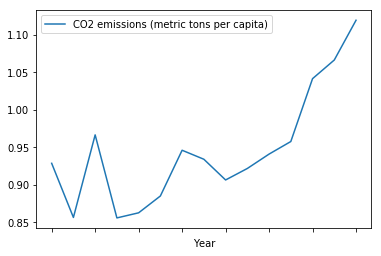

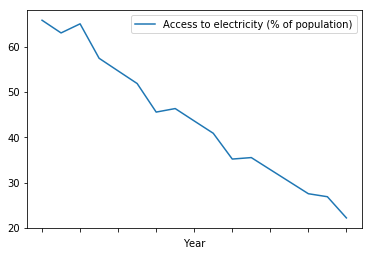

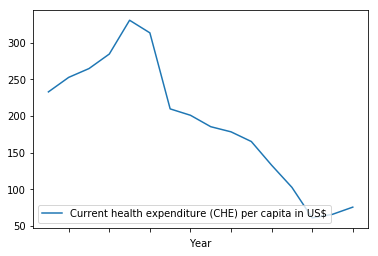

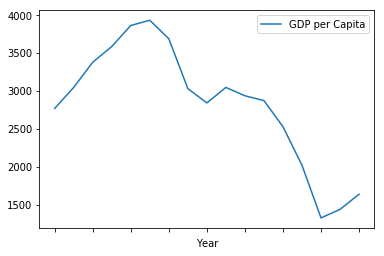

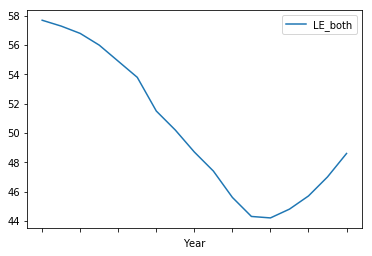

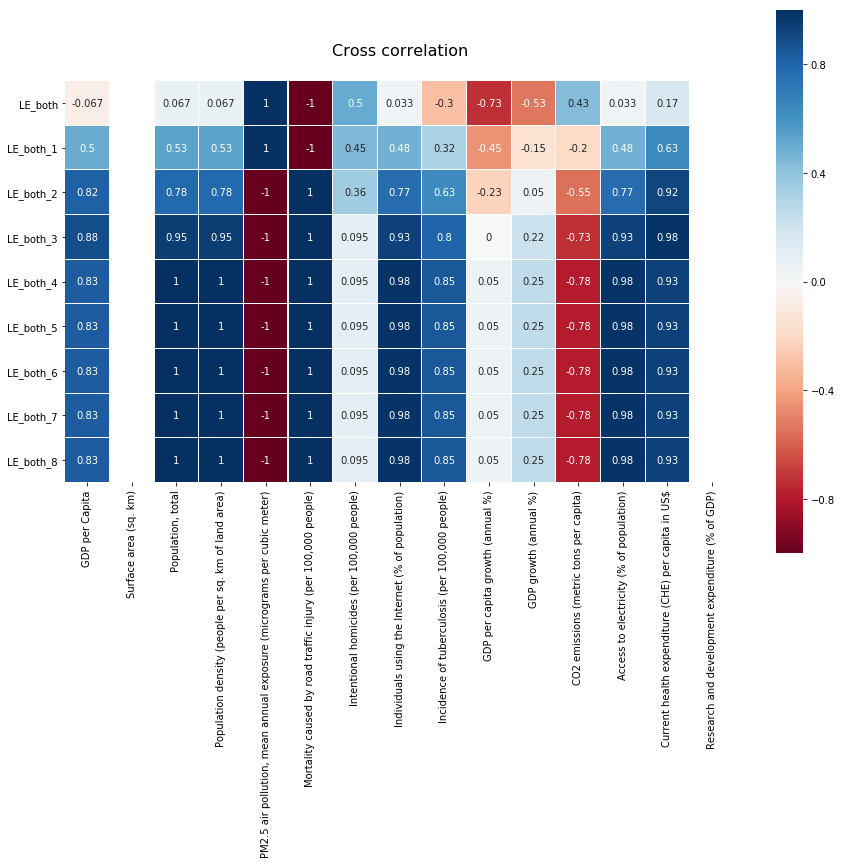

In [108]:
# let's have a look at correlation of Eswatini
df_data_country = df_data.groupby('Country')

df_eswatini= df_data_country.get_group('Eswatini')
df_eswatini_reset = df_eswatini.reset_index(0)
display(df_eswatini_reset[df_eswatini_reset.columns[[16]]].plot())
display(df_eswatini_reset[df_eswatini_reset.columns[[17]]].plot())
display(df_eswatini_reset[df_eswatini_reset.columns[[18]]].plot())
display(df_eswatini_reset[df_eswatini_reset.columns[[5]]].plot())
display(df_eswatini_reset[df_eswatini_reset.columns[[1]]].plot())
df_afg_corr = calculate_cross_correlation(df_eswatini)
display(df_afg_corr.T)
display_cross_correlation(df_afg_corr)

We gonna have an overall look at the correaltion by calculating the correlation of every country and the calculate the average of all countries

In [95]:

#initialise a df for every single feature with it's lagged life exp. 
#column_names = df_data.filter(regex='^(?!Life exp).*$',axis=1).columns.tolist()

def calculate_overall_correlation(df_data):
    df_data_country = df_data.groupby('Country')
    df_accum_corr = None
    count = 0
    for index, country in df_data_country: 
        df_corr = calculate_cross_correlation(country)
        df_corr.fillna(0, inplace=True) #if we still have NaNs just replace them with zero to at least get a value
        count += 1
        if  df_accum_corr is None:
            df_accum_corr = df_corr
        else:
            df_accum_corr += df_corr

    df_accum_corr = df_accum_corr/count
    return df_accum_corr



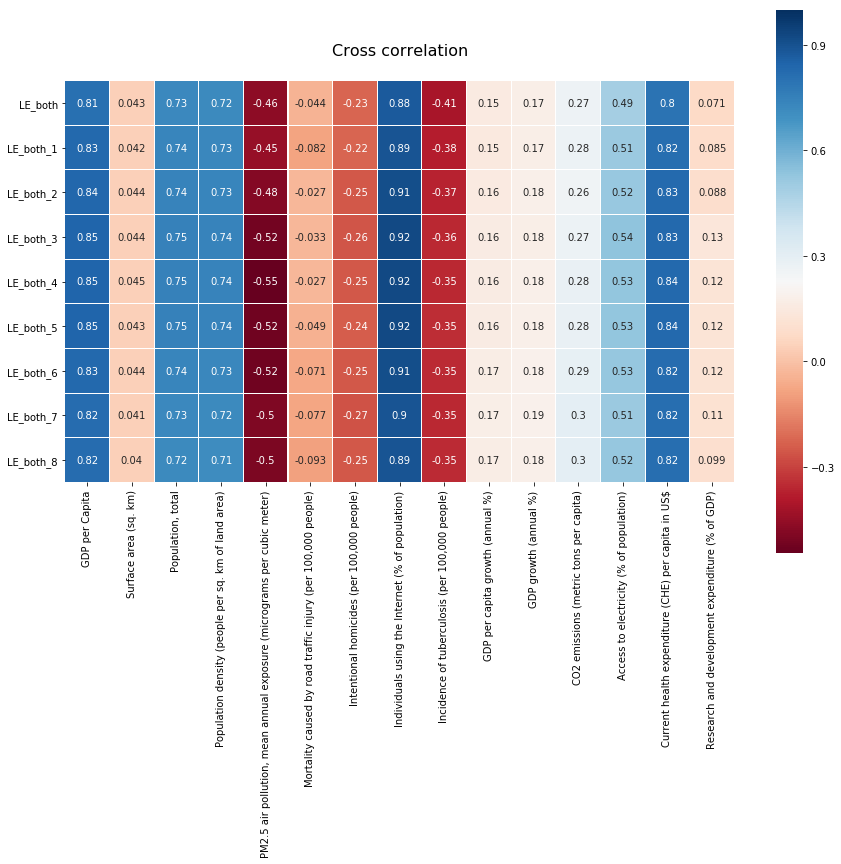

In [96]:
df_corr_overall = calculate_overall_correlation(df_data)
display_cross_correlation(df_corr_overall)

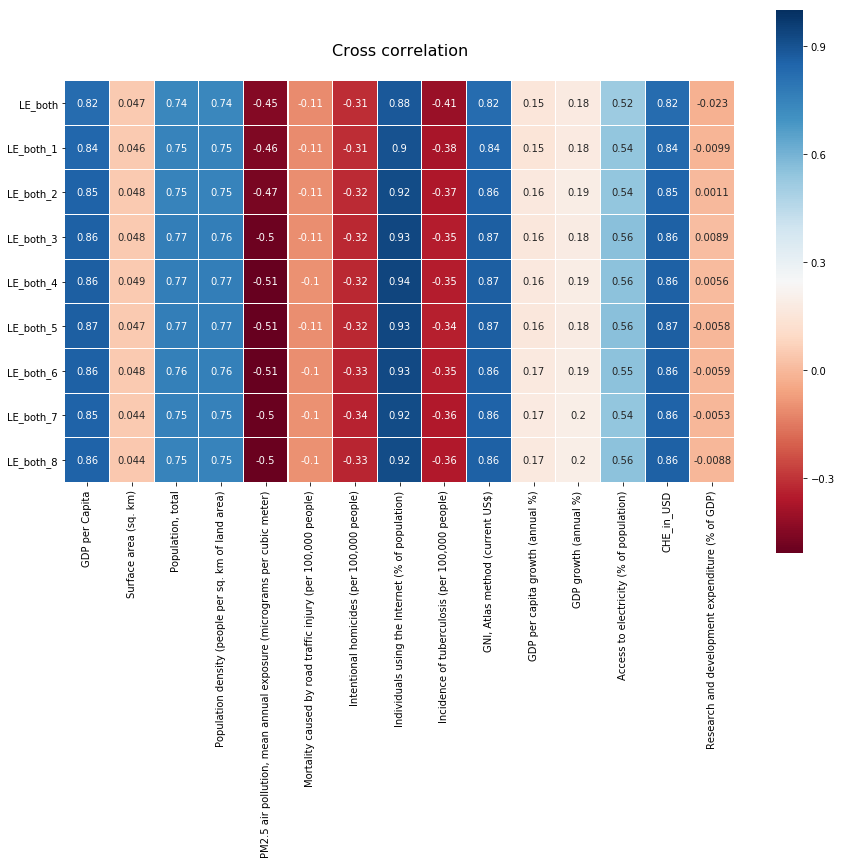

In [97]:
#until now we used the raw data, let's have a look at the processed data frmo attila
df_corr_overall = calculate_overall_correlation(df_data_preprocessed)
display_cross_correlation(df_corr_overall)
# this plot looks completly different, and by further investigations, I found out that most of the columns of the preproccesd files contain the year as a value. 
# there is something wrong with preproccesing

Interpolating the data we can not see much of a difference in the values. 
What we can see is a shift of the highest correlation one year back. So the highest correlation is around LE_both_4 and LE_Both_5. Before it was LE_both_3 and LE_Both_4.



So just blindly calculating correlations and take good values as indicator for (higher) life. exp. is not a good idea. 
For example the CO2 emissions __positivly__ correlate with the life exp., but would not make sense. Since this is not good for human, it actually should decrease the life exp.. 

But since such values also correlate with GDP, which also correlates with life. exp. again, we can conclude that more money for industry also cars ect. could mean more money for health which again increase age. 

So it's actually life exp. and CO2 emission correlating with GDP but not with eachother. 

# Look at some countries with the biggest variance in life exp if the correlation is still the case

We gonna filter countries with high variance in life exp. and analsyse the correlation their.

['Rwanda',
 'Botswana',
 'Zambia',
 'Haiti',
 'Malawi',
 'Zimbabwe',
 'Uganda',
 'Kenya',
 'Angola',
 'Ethiopia',
 'Eswatini',
 'United Republic of Tanzania',
 'Sierra Leone',
 'Congo',
 'Namibia']

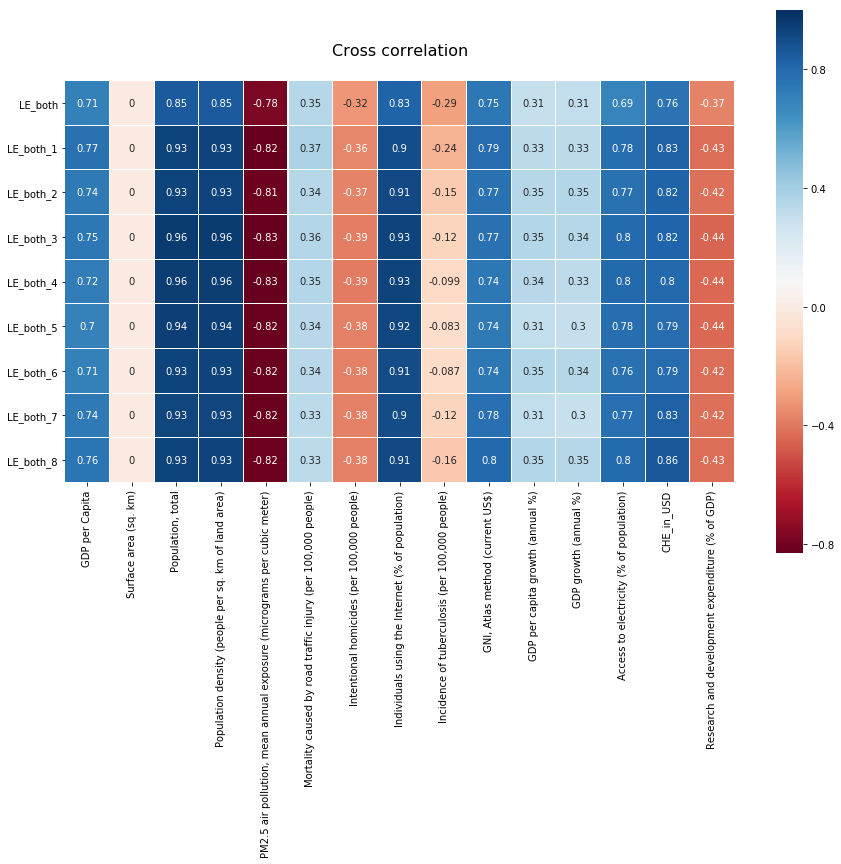

In [141]:
#find countries with the highest variance in life exp. 
country_names_high_life_var = df_data_preprocessed['LE_both'].groupby('Country').var().sort_values(ascending=False).index.tolist()[:15] #choose the first 15
display(country_names_high_life_var)
df_data_high_var_life =  df_data_preprocessed.loc[country_names_high_life_var]
#calculate correlation
df_corr_overall = calculate_overall_correlation(df_data_high_var_life)
display_cross_correlation(df_corr_overall)

Looking at the correlation plot we see  not very much different results in the values, but again a shift in time. 
Now it's again between LE_both3 and LE_both4 the highest values. All of these countries are actually African countries and this change could indicate that for example an increase in GDP faster influences the Life expectancy. Since they have much lower life exp. than other countries, for example an investment in afforadble drugs or free condoms (HIV) would change the life exp. rather fast. In countries with already high life exp. there needs t

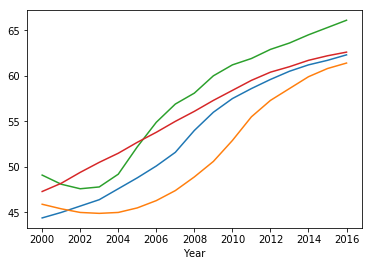

In [139]:
display(df_data_preprocessed['LE_both'].loc['Zambia'].plot())
display(df_data_preprocessed['LE_both'].loc['Zimbabwe'].plot())
display(df_data_preprocessed['LE_both'].loc['Botswana'].plot())
display(df_data_preprocessed['LE_both'].loc['Angola'].plot())